# Capstone 2: Pre-processing #

This stage of the project will involve preparing the data for machine learning. This will include selecting appropriate features, imputing null values with sensible estimates, splitting the data into training and testing sets, and finally scaling the data. When imputing values and scaling the data it is important to avoid data leakage. This happens when information from the test set indirectly influences machine learning models.

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
import pickle as pkl

In [2]:
# Create a dataframe from the CSV file containing the analyzed data
data = pd.read_csv('analyzed_data.csv')
data.head()

,date,comuna,house,new,total_area,built_area,bedrooms,bathrooms,furnished,address,description,price_uf,days_old,zone
0,2020-09-10,Puente Alto,0,0,42.0,NaN,2.0,1.0,0,"Puente Alto, Sgto Menadier 2779","Departamento ubicado en segundo piso, en plena...",871.42,0,southeast
1,2020-09-09,Ñuñoa,0,0,70.0,NaN,2.0,2.0,0,"Ñuñoa, Irarrázaval 1401",Depto Vista despejada 2D 2B E B *2 dormitorios...,4900.00,1,east
2,2020-09-09,Santiago,0,0,23.0,NaN,1.0,1.0,0,"Santiago, Huérfanos",Oportunidad Inversionistas o particulares. Ven...,1575.00,1,center
3,2020-09-09,Las Condes,0,0,163.0,NaN,3.0,4.0,0,"Santiago, Vespucio Norte","Vespucio Norte, Las Condes, Vendo confortable ...",13500.00,1,northeast
4,2020-09-09,Ñuñoa,0,0,85.0,NaN,3.0,1.0,0,"Ñuñoa, Fidias a 3 cuadras metro Ñuble",Amplio y luminoso departamento dúplex en Villa...,3346.26,1,east


Below we select the features that we want to use in the model. In the EDA stage of the project we saw which features have strong correlations with price.  Since the columns `new`, `furnished`, and `days_old` had very weak correlations with price, these columns will not be used. We will also discard `date`, `comuna`, `address`, and `description`, making `zone` the only non-numerical column.

In [3]:
# Select the features that will be used
df = data.loc[:,['house', 'total_area', 'built_area', 'bedrooms', 'bathrooms', 'zone', 'price_uf']]
df.head()

,house,total_area,built_area,bedrooms,bathrooms,zone,price_uf
0,0,42.0,NaN,2.0,1.0,southeast,871.42
1,0,70.0,NaN,2.0,2.0,east,4900.00
2,0,23.0,NaN,1.0,1.0,center,1575.00
3,0,163.0,NaN,3.0,4.0,northeast,13500.00
4,0,85.0,NaN,3.0,1.0,east,3346.26


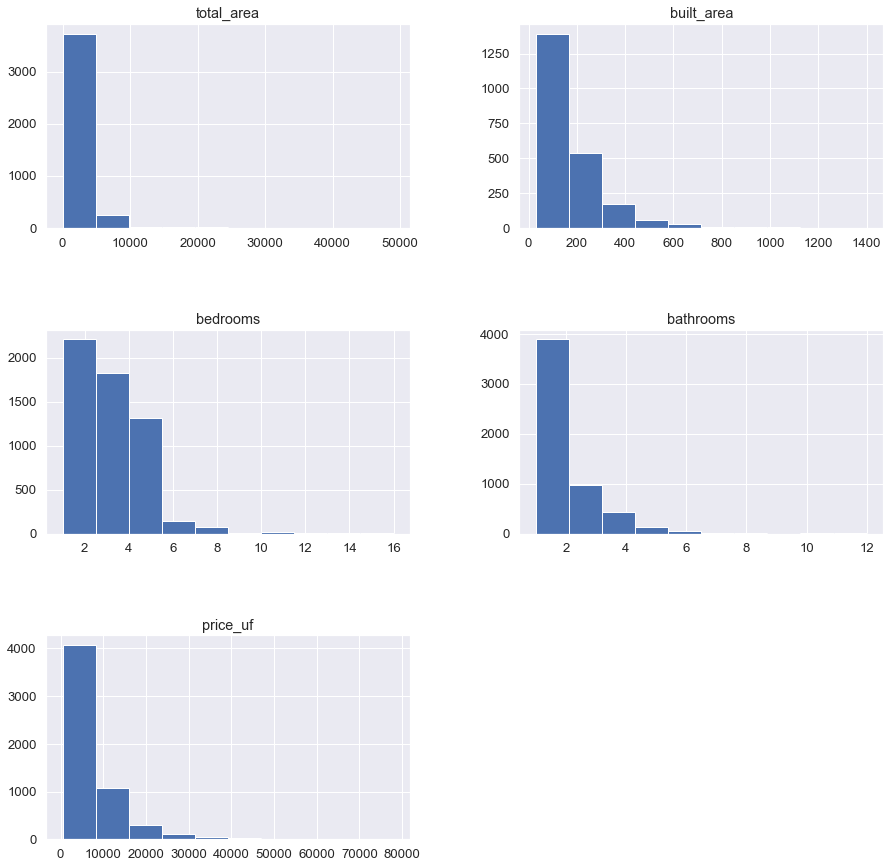

In [4]:
# Have a look at the distributions of the numerical features
sns.set(font_scale=1.2)
df[['total_area', 'built_area', 'bedrooms', 'bathrooms', 'price_uf']].hist(figsize=(15,15))
plt.subplots_adjust(hspace=0.5);

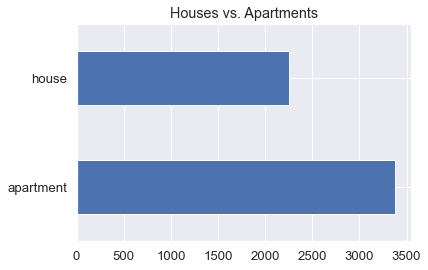

In [5]:
# See number of houses vs apartments, mapping 0 and 1 to their meanings
mapping = {0: 'apartment', 1: 'house'}
df['house'].replace(mapping).value_counts().plot(kind='barh', title='Houses vs. Apartments')
plt.show()

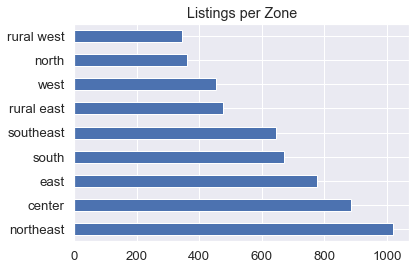

In [6]:
# See number of listings per zone
df['zone'].value_counts().plot(kind='barh', title='Listings per Zone')
plt.show()

In [7]:
# See which columns are missing the most data
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='%', ascending=False)

,count,%
built_area,3429,60.884233
total_area,1617,28.710938
bathrooms,132,2.343750
bedrooms,29,0.514915
house,0,0.000000
zone,0,0.000000
price_uf,0,0.000000


Over 60% of the listings have null values for `built_area`. However, this is not as big of a problem as it might appear. Below we see that almost all of the listings with missing values for `built_area` are apartments. Remember that apartments only include values for `total_area`. One might argue that the sensible choice would be to drop the `built_area` column, however this column has a very high correlation with price, so we would lose potentially valuable information. If the listing is an apartment we can essentially argue that `total_area` and `built_area` are equivalent, so we will use the values for `total_area` to fill in the missing `built_area` values for apartments. This does not solve the problem of missing values in the `total_area` column, but we will deal with them later.

In [8]:
# Almost all of the missing values for built_area are for apartments
df[df['built_area'].isnull()]['house'].value_counts()

0    3382
1      47
Name: house, dtype: int64

In [9]:
# Same is true for total_area
df[df['total_area'].isnull()]['house'].value_counts()

0    1583
1      34
Name: house, dtype: int64

In [10]:
# For apartments, fill missing built_area with total_area
indices = df['house'] == 0
df.loc[indices, 'built_area'] = df.loc[indices, 'built_area'].fillna(df['total_area'])
df.head()

,house,total_area,built_area,bedrooms,bathrooms,zone,price_uf
0,0,42.0,42.0,2.0,1.0,southeast,871.42
1,0,70.0,70.0,2.0,2.0,east,4900.00
2,0,23.0,23.0,1.0,1.0,center,1575.00
3,0,163.0,163.0,3.0,4.0,northeast,13500.00
4,0,85.0,85.0,3.0,1.0,east,3346.26


In [11]:
# Drop missing values for house areas, as there are not many and they are difficult to guess
print('Rows before:', df.shape[0])
df = df[~((df.house == 1) & (df.total_area.isnull() | df.built_area.isnull()))]
print('Rows after:', df.shape[0])

Rows before: 5632
Rows after: 5551


Now we will create dummy variables for the different zones that were created in the previous stage.  A variable will be made for each zone except for 'center'. Listings in this zone will have a value of zero for all of the zones. This prevents redundancy.

In [12]:
# See the unique values for 'zone'. All but one will become a column
df['zone'].unique()

array(['southeast', 'east', 'center', 'northeast', 'north', 'south',
       'west', 'rural east', 'rural west'], dtype=object)

In [13]:
# Create dummy variables from "zone" feature
df = pd.get_dummies(df, columns=['zone'], drop_first='True')
df.head()

,house,total_area,built_area,bedrooms,bathrooms,price_uf,zone_east,zone_north,zone_northeast,zone_rural east,zone_rural west,zone_south,zone_southeast,zone_west
0,0,42.0,42.0,2.0,1.0,871.42,0,0,0,0,0,0,1,0
1,0,70.0,70.0,2.0,2.0,4900.00,1,0,0,0,0,0,0,0
2,0,23.0,23.0,1.0,1.0,1575.00,0,0,0,0,0,0,0,0
3,0,163.0,163.0,3.0,4.0,13500.00,0,0,1,0,0,0,0,0
4,0,85.0,85.0,3.0,1.0,3346.26,1,0,0,0,0,0,0,0


In [14]:
# See how much missing data is left
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='%', ascending=False)

,count,%
total_area,1583,28.517384
built_area,1583,28.517384
bathrooms,127,2.287876
bedrooms,18,0.324266
house,0,0.000000
price_uf,0,0.000000
zone_east,0,0.000000
zone_north,0,0.000000
zone_northeast,0,0.000000
zone_rural east,0,0.000000


In [15]:
# Make sure the data types are all numerical (categorical features are now binary)
df.dtypes

house                int64
total_area         float64
built_area         float64
bedrooms           float64
bathrooms          float64
price_uf           float64
zone_east            uint8
zone_north           uint8
zone_northeast       uint8
zone_rural east      uint8
zone_rural west      uint8
zone_south           uint8
zone_southeast       uint8
zone_west            uint8
dtype: object

Now it is time to deal with the missing values for `bedrooms` and `bathrooms`. In the Data Wrangling stage of the process we already dropped the rows that were missing both values, so now we can use whichever value is present to estimate the value that is missing. The cells below shows there are on average 0.78 bathrooms per bedroom in a given home, and the median numbers of bedrooms and bathrooms are 3 and 2 respectively. For each row, if the value for `bathrooms` is missing, we fill it by multiplying the value for `bedrooms` by 2/3 and rounding up to the nearest whole number. Conversely, to fill in the the missing values for `bedrooms` we will multiply the value for `bedrooms` by 3/2, and round down to the nearest integer.

In [16]:
ratio = df['bathrooms'] / df['bedrooms']
ratio.mean()

0.7787528771019337

In [17]:
# Determine typical ratio of bedrooms to bathrooms
df[['bedrooms', 'bathrooms']].median()

bedrooms     3.0
bathrooms    2.0
dtype: float64

In [18]:
# Use ratio to impute sensible values
df['bathrooms'].fillna(df['bedrooms']*(2/3), inplace=True)
df['bathrooms'] = df['bathrooms'].apply(np.ceil).astype(int)

df['bedrooms'].fillna(df['bathrooms']*(3/2), inplace=True)
df['bedrooms'] = df['bedrooms'].astype(int)

In [19]:
# Check for remaining null values
df.isnull().sum()

house                 0
total_area         1583
built_area         1583
bedrooms              0
bathrooms             0
price_uf              0
zone_east             0
zone_north            0
zone_northeast        0
zone_rural east       0
zone_rural west       0
zone_south            0
zone_southeast        0
zone_west             0
dtype: int64

There are still apartments missing values for both `built_area` and `total_area`. To fill these will take the median `total_area` of apartments from the training set and use those values to fill the training and test sets.

In [20]:
# Get median area of apartments
median_area = df[df['house']==0]['total_area'].median()
print(median_area)

64.0


In [21]:
# Use this to impute values for apartments missing area values
df.fillna(median_area, inplace=True)

In [22]:
# Make sure there are no more null values
df.isnull().sum()

house              0
total_area         0
built_area         0
bedrooms           0
bathrooms          0
price_uf           0
zone_east          0
zone_north         0
zone_northeast     0
zone_rural east    0
zone_rural west    0
zone_south         0
zone_southeast     0
zone_west          0
dtype: int64

Next it is time to split the data into training and test sets. `price_uf` will be set as the target value, and the data will be stratified using the `house` column to make sure there is roughly the same ratio of houses and apartments in the training and test sets.

In [24]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='price_uf'), 
                                                    df.price_uf, test_size=0.3, 
                                                    stratify=df.house, random_state=47)

In [25]:
# Check shape
X_train.shape, X_test.shape

((3885, 13), (1666, 13))

In [26]:
y_train.shape, y_test.shape

((3885,), (1666,))

Finally, we need to scale the data, since our features are on vastly different scales. Also, some of the features are highly skewed, and most machine learning models work best with data that is more or less normally distributed. Power Transformer uses logarithmic transformation to make the data more closely resemble a normal distribution. When we fit the transformer to the data, it determines what power is optimal for each feature. We will fit the transformer to the training set and then use it to transform both the training and test sets.

In [27]:
# Create instance of PowerTransformer and fit to training set
power = PowerTransformer(copy=False)
power.fit(X_train)

PowerTransformer(copy=False)

In [28]:
# The lambda parameter shows the power of the transformation
print(power.lambdas_)

[ -1.94842869  -0.57345936  -0.53974889  -0.05042685  -0.59459446
 -10.32130606 -22.97073585  -7.64056609 -17.67994733 -24.0552137
 -12.52033369 -12.13533244 -17.79227184]


In [29]:
# Transform training and test sets
X_train_scaled = power.transform(X_train)
X_test_scaled = power.transform(X_test)

In [30]:
# Outputs are numpy arrays, so change them back to pandas DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns= X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= X_test.columns)
X_train_scaled.head()

,house,total_area,built_area,bedrooms,bathrooms,zone_east,zone_north,zone_northeast,zone_rural east,zone_rural west,zone_south,zone_southeast,zone_west
0,1.248715,0.600521,0.620878,2.178508,0.919623,-0.401790,-0.258872,-0.474516,-0.298069,-0.252588,-0.360579,2.725313,-0.297044
1,1.248715,0.688534,0.149475,0.224363,0.919623,-0.401790,-0.258872,-0.474516,-0.298069,3.959018,-0.360579,-0.366930,-0.297044
2,-0.800823,-1.608512,-1.742633,-1.799294,-1.315618,-0.401790,-0.258872,-0.474516,-0.298069,-0.252588,-0.360579,-0.366930,3.366502
3,-0.800823,-0.600592,-0.463586,0.224363,0.102062,2.488864,-0.258872,-0.474516,-0.298069,-0.252588,-0.360579,-0.366930,-0.297044
4,1.248715,0.723579,0.241302,-0.606953,-1.315618,-0.401790,-0.258872,-0.474516,-0.298069,-0.252588,-0.360579,2.725313,-0.297044


Below are histograms of the original and scaled data showing how the distributions have shifted. 

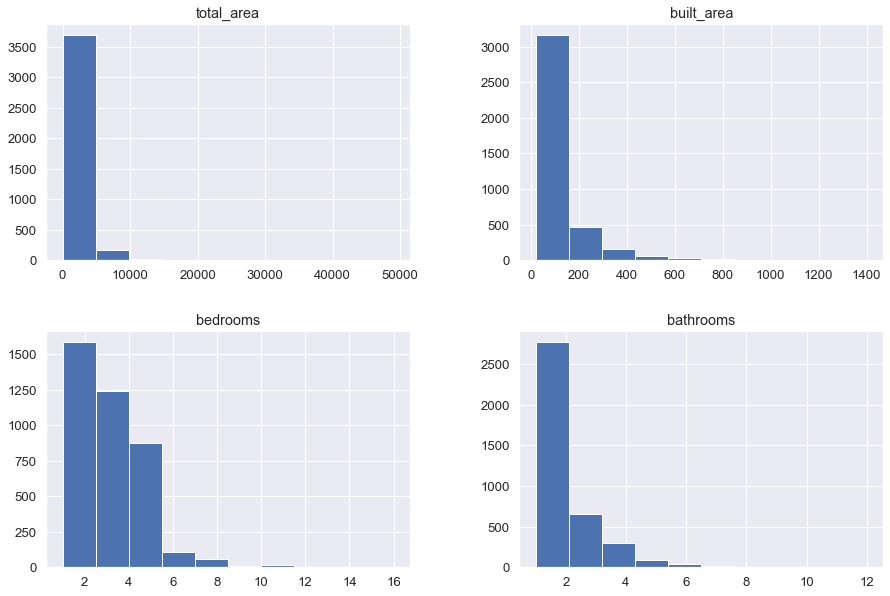

In [31]:
# Original distributions of numerical features before scaling
X_train[['total_area', 'built_area', 'bedrooms', 'bathrooms']].hist(figsize=(15, 10));

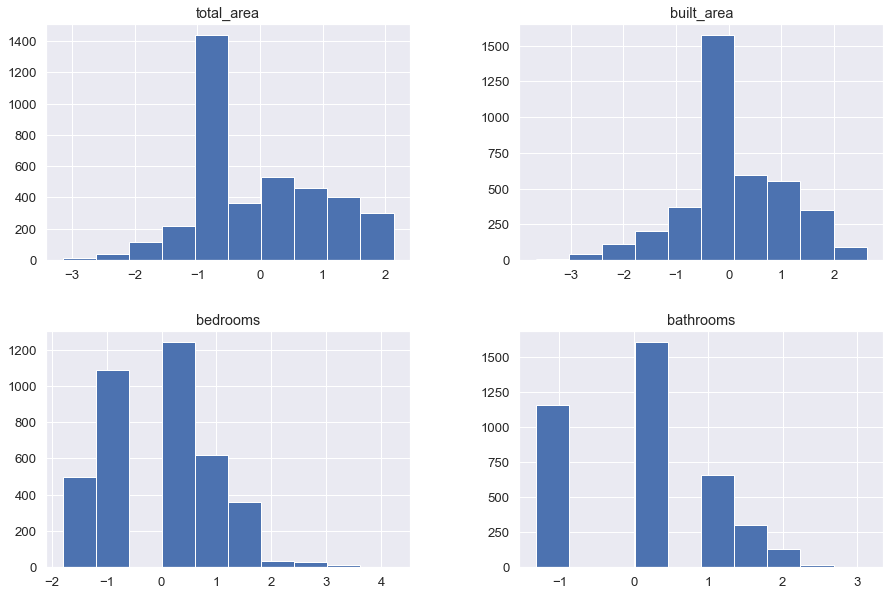

In [32]:
# Distributions of numerical after scaling
X_train_scaled[['total_area', 'built_area', 'bedrooms', 'bathrooms']].hist(figsize=(15, 10));

The distribution of the `house` column (as well as the other binary columns which are not shown) look the same as before, although the values are no londer 0 and 1. We can also see that the ratio of houses to apartments below is the same as the ratio in the dataset before the train/test split because we split the data in a stratified way, using this feature.

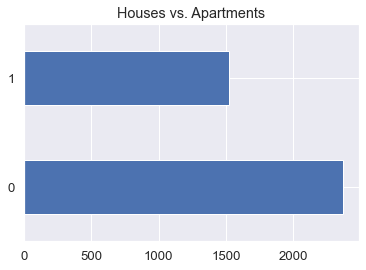

In [33]:
# Ratio of houses to apartments in training set (houses represented by 1)
X_train['house'].value_counts().plot(kind='barh', title='Houses vs. Apartments')
plt.show()

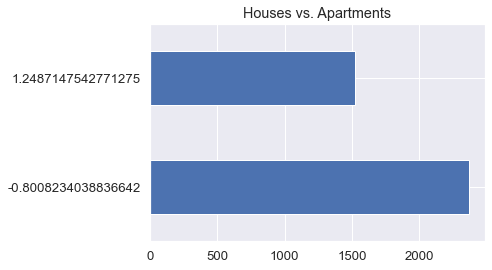

In [34]:
# Ratio after scaling
X_train_scaled['house'].value_counts().plot(kind='barh', title='Houses vs. Apartments')
plt.show()

In [36]:
# Save train and test data, both original and scaled
X_train.to_csv('train_data/X_train.csv', index=False)
X_train_scaled.to_csv('train_data/X_train_scaled.csv', index=False)
y_train.to_csv('train_data/y_train.csv', index=False)

X_test.to_csv('test_data/X_test.csv', index=False)
X_test_scaled.to_csv('test_data/X_test_scaled.csv', index=False)
y_test.to_csv('test_data/y_test.csv', index=False)